# STARDUST interactive

This Jupyter Notebook provides an interactive version of STARDUST signal stats extraction. Please see the biorxiv paper and github page for more information. 

## Environment set up

In [22]:
import os, scipy, sys, pandas as pd, numpy as np, datetime, seaborn as sns
from util import * # import functions from util.py

## Data input

In [23]:
# input input and output directories
input_dir = input('Enter the path to the folder containing the input files: ')
output_dir = input('Enter the path to the folder containing the output files: ')

In [24]:
# input metadata related to the experiment
keyword = input('Enter the common keyword in input file (csv, ROA mask and cell mask) names: ')
experiment_date = input('Enter the experiment date (e.g. 2023-11-06): ')
mouse_ID = input('Enter the mouse ID: ')
slice_number = int(input('Enter the slice number: '))
drug_frame = float(input('Enter the frame number of drug application (enter 0 if no drug was applied): '))
frame_rate = int(input("Enter the frame rate (in Hz) of the recording (e.g. 20): "))
output_filename = input('Enter the output file name: ')
output_path = os.path.join(output_dir, output_filename)


In [25]:
# find the input files
csv_path, ROA_mask_path, cell_mask_path = find_files(input_dir, keyword)

Found the following files: 

CSV file:  /Users/mikodai/Desktop/Calcium imaging/Analysis/20240409_slice0_recording0_acsf_signal.csv
ROA mask:  /Users/mikodai/Desktop/Calcium imaging/Analysis/20240409_slice0_recording0_acsf_10to12_roamask.tif
Cell mask:  /Users/mikodai/Desktop/Calcium imaging/Analysis/20240409_slice0_recording0_acsf_cellmask.tif


In [26]:
ROA_map_labeled, ROA_map_count, cell_map_labeled, cell_count = read_masks(ROA_mask_path, cell_mask_path)

ROA mask contains 1132 ROAs
Cell mask contains 23 cells


## Signal preprocessing

In [27]:
# Smooth traces using a filter
filtered_traces = raw_to_filtered(csv_path)

Reading in file:  /Users/mikodai/Desktop/Calcium imaging/Analysis/20240409_slice0_recording0_acsf_signal.csv 




The current file contains: 
Number of ROA:  1132
Number of frames:  635

Applying a lowpass Butterworth filter with a 4 th order filter at the cutoff of 0.4 Hz


In [28]:
ROA_count, frame_count = check_traces(filtered_traces)

The current file contains: 
Number of ROA:  1132
Number of frames:  635


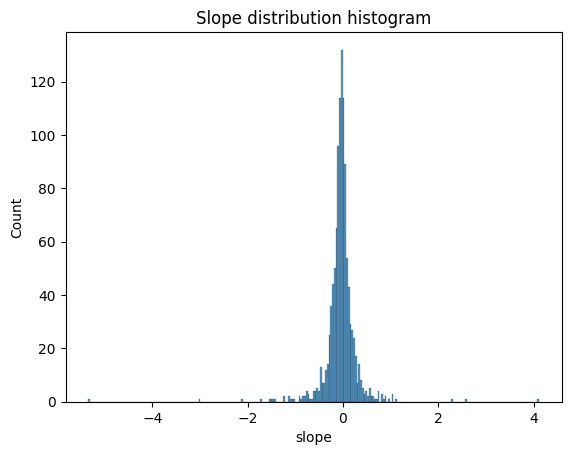

In [29]:
# optional: correct traces for shift using linear regression
corrected_traces, reg = correct_shift(filtered_traces)

### Checkpoint 1: slope

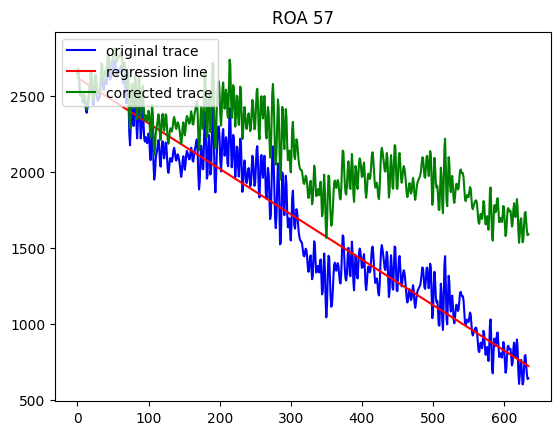

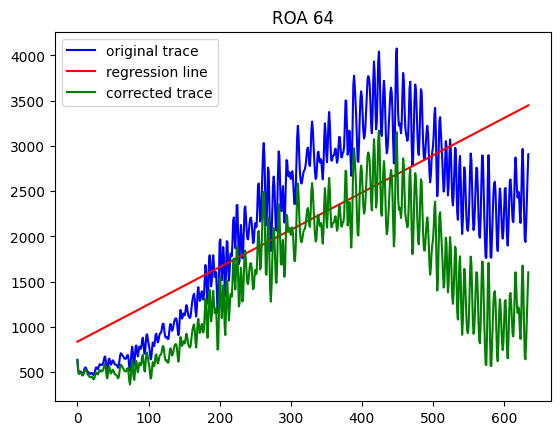

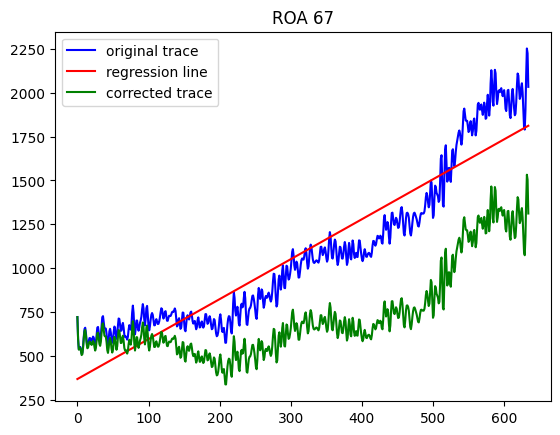

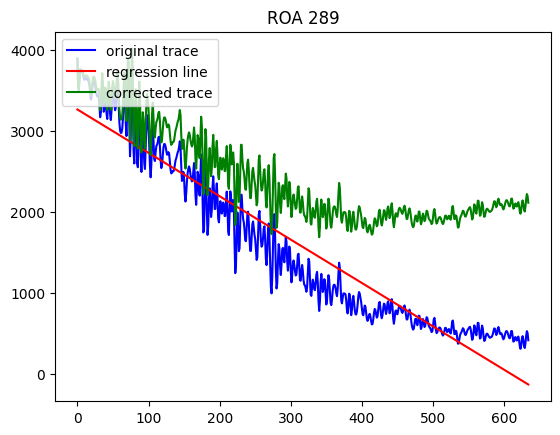

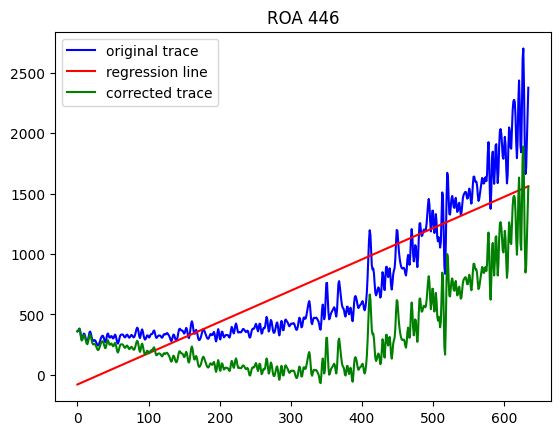

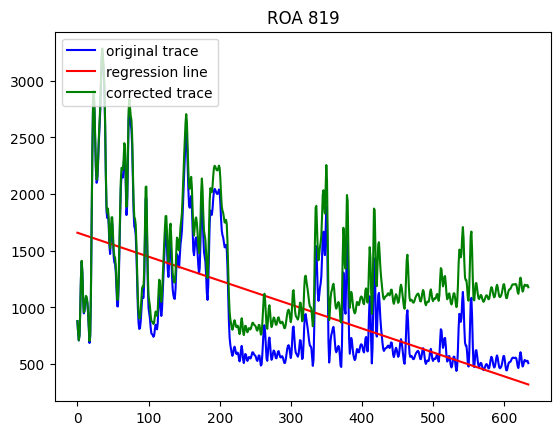

In [30]:
# optional visualization point
check_correction(filtered_traces, corrected_traces, reg)

## Baseline determination

In [31]:
# baseline determination
dff_traces, baselines, thresholds, signal_frames, signal_boundaries = iterative_baseline(corrected_traces)


Processing round 1 of signal detection...
ROAs with signal:  1096
ROAs without signal:  36

Processing round 2 of signal detection...
ROAs with signal:  1096
ROAs without signal:  36

Processing round 3 of signal detection...
ROAs with signal:  1095
ROAs without signal:  37

Processing round 4 of signal detection...
ROAs with signal:  1096
ROAs without signal:  36

Processing round 5 of signal detection...
ROAs with signal:  1096
ROAs without signal:  36

Processing round 6 of signal detection...
ROAs with signal:  1095
ROAs without signal:  37



### Checkpoint 2: individual trace

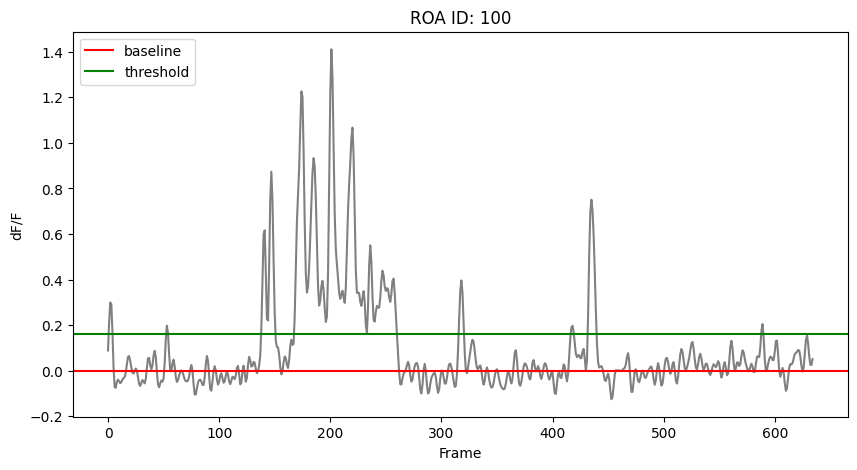

In [92]:
# optional: visualize specific trace
inspect_trace(100, dff_traces, baselines, thresholds, drug_frame)

## Signal detection

In [34]:
# signal detection
# analyze signals and output signal_stats
signal_stats = analyze_signal(dff_traces, signal_frames, signal_boundaries, frame_rate, drug_frame)

In [35]:
signal_stats.head()

ROA_ID  signal_start_index  signal_end_index  peak_index  peak_time  \
0       1                 173               180         176      176.0   
1       1                 480               487         483      483.0   
2       2                 148               154         151      151.0   
3       2                 191               221         205      205.0   
4       2                 426               460         436      436.0   

         AUC  amplitude  signal_to_noise  rise_time  decay_time  half_width  \
0   2.979658   0.923955         0.642804   2.276649    2.344761    0.428436   
1   2.830177   0.825278         0.574153   2.299996    2.272914    0.391500   
2   1.131619   0.410298         0.379186   2.013160    2.178127    0.186197   
3   6.061721   0.477321         0.441127  12.597958    4.844746    0.233239   
4  11.432377   0.922440         0.852494   3.821000   12.599557    0.448774   

   duration  inter_event_interval Drug  
0       7.0                   NaN   NA  
1       7.0                 300.0   NA  
2       6.0                   NaN   NA  
3      30.0                  37.0   NA  
4      34.0                 205.0   NA

## Cell assignment

In [36]:
# add corresponding cell ID to the signal stats
df_ROA_cell = align_ROA_cell(ROA_map_labeled, cell_map_labeled, ROA_map_count)
signal_stats = pd.merge(df_ROA_cell, signal_stats, on = 'ROA_ID', how = 'right')

In [37]:
signal_stats.head(10)

ROA_ID  cell_ID  signal_start_index  signal_end_index  peak_index  \
0       1        1                 173               180         176   
1       1        1                 480               487         483   
2       2        1                 148               154         151   
3       2        1                 191               221         205   
4       2        1                 426               460         436   
5       2        1                 500               512         503   
6       3        1                 178               214         207   
7       3        1                 233               265         243   
8       3        1                 346               356         349   
9       3        1                 476               504         485   

   peak_time        AUC  amplitude  signal_to_noise  rise_time  decay_time  \
0      176.0   2.979658   0.923955         0.642804   2.276649    2.344761   
1      483.0   2.830177   0.825278         0.574153   2.299996    2.272914   
2      151.0   1.131619   0.410298         0.379186   2.013160    2.178127   
3      205.0   6.061721   0.477321         0.441127  12.597958    4.844746   
4      436.0  11.432377   0.922440         0.852494   3.821000   12.599557   
5      503.0   1.910943   0.310959         0.287380   1.952959    7.063921   
6      207.0   4.943281   0.422083         0.442542  21.963871    5.677845   
7      243.0  15.434334   1.234163         1.293983   7.248788   19.332457   
8      349.0   0.921455   0.265443         0.278309   2.086849    5.508711   
9      485.0   4.200291   0.356593         0.373878   5.897306   17.637156   

   half_width  duration  inter_event_interval Drug  
0    0.428436       7.0                   NaN   NA  
1    0.391500       7.0                 300.0   NA  
2    0.186197       6.0                   NaN   NA  
3    0.233239      30.0                  37.0   NA  
4    0.448774      34.0                 205.0   NA  
5    0.140868      12.0                  40.0   NA  
6    0.202114      36.0                   NaN   NA  
7    0.610372      32.0                  19.0   NA  
8    0.115798      10.0                  81.0   NA  
9    0.173690      28.0                 120.0   NA

### ROA based analysis

In [84]:
ROA_based, df_ROA_cell = ROA_analysis(signal_stats, df_ROA_cell)

In [85]:
ROA_based

ROA_ID  cell_ID  ROA_type         AUC  amplitude  signal_to_noise  \
0          1        1        NA    2.904917   0.874616         0.608479   
1          2        1        NA    5.134165   0.530254         0.490047   
2          3        1        NA    6.374840   0.569570         0.597178   
3          4        2        NA   45.434220   0.745207         0.836153   
4          5        1        NA  153.624356   2.635699         4.125591   
...      ...      ...       ...         ...        ...              ...   
1127    1128       21        NA   12.422644   0.945550         1.805188   
1128    1129        0        NA   18.141584   1.705015         0.640169   
1129    1130       20  inactive         NaN        NaN              NaN   
1130    1131       23        NA    5.133989   0.539356         1.988472   
1131    1132       23        NA    5.535995   0.767326         1.335233   

      rise_time  decay_time  half_width    duration  inter_event_interval  \
0      2.288323    2.308838    0.409968    7.000000            300.000000   
1      5.096269    6.671588    0.252269   20.500000             94.000000   
2      9.299204   12.039042    0.275494   26.500000             73.333333   
3      2.108718   52.046094    0.363864  108.000000              1.000000   
4     31.584589   53.106846    1.311020  107.000000                   NaN   
...         ...         ...         ...         ...                   ...   
1127   4.931901    8.870077    0.455239   26.636364             20.600000   
1128   2.280343   13.087542    0.815665   19.833333             59.400000   
1129        NaN         NaN         NaN         NaN                   NaN   
1130   7.339214    6.325426    0.263616   27.363636             19.300000   
1131   3.407284    6.033146    0.376189   20.187500             16.000000   

      signal_count  
0              2.0  
1              4.0  
2              4.0  
3              2.0  
4              1.0  
...            ...  
1127          11.0  
1128           6.0  
1129           NaN  
1130          11.0  
1131          16.0  

[1132 rows x 12 columns]

### Checkpoint 3: ROA signals

<Axes: xlabel='signal_count', ylabel='Count'>

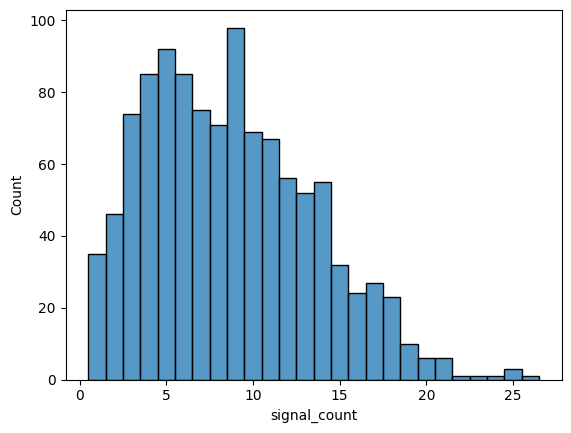

In [40]:
sns.histplot(data = ROA_based, x = 'signal_count', discrete = True)

In [77]:
df_ROA_cell

ROA_ID  cell_ID  ROA_type
0          1        1        NA
1          2        1        NA
2          3        1        NA
3          4        2        NA
4          5        1        NA
...      ...      ...       ...
1127    1128       21        NA
1128    1129        0        NA
1129    1130       20  inactive
1130    1131       23        NA
1131    1132       23        NA

[1132 rows x 3 columns]

In [78]:
df_ROA_cell.loc[df_ROA_cell['cell_ID'] == 0]

ROA_ID  cell_ID ROA_type
23        24        0       NA
162      163        0       NA
257      258        0       NA
263      264        0       NA
284      285        0       NA
291      292        0       NA
399      400        0       NA
428      429        0       NA
454      455        0       NA
549      550        0       NA
551      552        0       NA
635      636        0       NA
662      663        0       NA
734      735        0       NA
854      855        0       NA
978      979        0       NA
1128    1129        0       NA

In [42]:
df_ROA_cell.groupby('ROA_type').count()

ROA_ID  cell_ID
ROA_type                 
inactive      37       37
on          1095     1095

### Checkpoint 4: ROA map visualization

In [26]:
import rasterio
from rasterio.plot import show

In [27]:
with rasterio.open(ROA_mask_path) as image:
    ROA_array = image.read()

/Users/mikodai/Desktop/STARDUST/.venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.



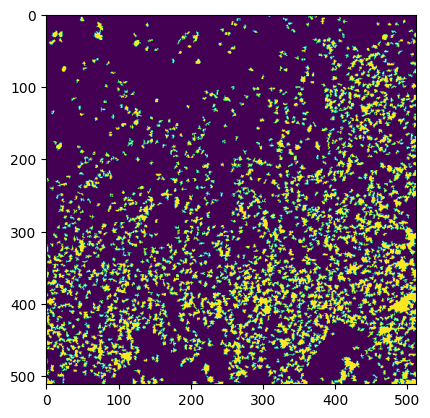

In [29]:
show(ROA_array);

In [22]:
import plotly.express as px
fig = px.imshow(ROA_map_labeled,
                labels = dict(x = 'X', y = 'Y', color = 'ROA ID'))
fig.show()

## Data output

In [79]:
signal_stats.to_csv(output_path + 'signal_stats.csv', index = False)
ROA_based.to_csv(output_path + 'ROA_based.csv', index = False)
df_ROA_cell.to_csv(output_path + 'ROA_cell.csv', index = False)